<a href="https://colab.research.google.com/github/noprisigit/mobilenetv2/blob/main/MobileNetV2%20-%20Percobaan%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [13]:
# Mount Google Drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/iarc-annocerv-master-dataset-split-balanced-augment1500.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/iarc-annocerv-master-dataset-split-balanced-augment1500.zip
replace iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AAAX4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AAAX4.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AAAZ4.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AABA2.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AABB2.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AABC1.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AABD1.jpg  
  inflating: iarc-annocerv-master-dataset-split-balanced-augment1500/train/CIN 1/AACG1.jpg  


In [14]:
data_dir = '/content/iarc-annocerv-master-dataset-split-balanced-augment1500'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(train_dir))
EPOCHS = 100
LEARNING_RATE = 1e-4

print(f'Jumlah Kelas: {NUM_CLASSES}')

Jumlah Kelas: 4


In [15]:
def count_dataset(directory):
  class_counts = {}
  total_count = 0

  for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)
    if (os.path.isdir(class_path)):
      num_images = len(os.listdir(class_path))
      class_counts[class_name] = num_images
      total_count += num_images

  return class_counts, total_count

total_images, class_distribution = count_dataset(train_dir)
print(f'Total Images Training: {total_images}')
print('Class Distribution Training:', class_distribution)

total_images, class_distribution = count_dataset(val_dir)
print(f'Total Images Validation: {total_images}')
print('Class Distribution Validation:', class_distribution)

Total Images Training: {'CIN 1': 1104, 'Normal': 770, 'CIN 3': 1104, 'CIN 2': 1104}
Class Distribution Training: 4082
Total Images Validation: {'CIN 1': 44, 'Normal': 26, 'CIN 3': 33, 'CIN 2': 31}
Class Distribution Validation: 134


In [16]:
# === DATA AUGMENTASI (selama training) ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# === DATASET LOADER ===
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4082 images belonging to 4 classes.
Found 134 images belonging to 4 classes.


In [17]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Tambahkan custom top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Bangun model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,046,212 (11.62 MB)

 Trainable params: 1,520,708 (5.80 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

end_time = time.time()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 73s 474ms/step - accuracy: 0.2708 - loss: 1.6076 - val_accuracy: 0.4478 - val_loss: 1.2893
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 50s 390ms/step - accuracy: 0.3683 - loss: 1.3447 - val_accuracy: 0.4627 - val_loss: 1.2846
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 375ms/step - accuracy: 0.4201 - loss: 1.2658 - val_accuracy: 0.4328 - val_loss: 1.2987
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 50s 391ms/step - accuracy: 0.4800 - loss: 1.2047 - val_accuracy: 0.4627 - val_loss: 1.2337
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 49s 385ms/step - accuracy: 0.4965 - loss: 1.1558 - val_accuracy: 0.5000 - val_loss: 1.2616
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 50s 394ms/step - accuracy: 0.5685 - loss: 1.0503 - val_accuracy: 0.4104 - val_loss: 1.4001
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 377ms/step - accuracy: 0.5660 - loss: 1.0145 - val_accuracy: 0.4104 - val_loss: 1.7186
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 50s 387ms/step - accuracy: 0.6110 -

128/128 ━━━━━━━━━━━━━━━━━━━━ 52s 403ms/step - accuracy: 0.5040 - loss: 1.1874
Train Accuracy: 0.5164
Train Loss: 1.1660
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5830 - loss: 0.9751
Val Accuracy: 0.4627
Val Loss: 1.2337

Best epoch: 5
Validation Accuracy at Best Epoch: 0.5000

🏁 Training selesai dalam 781.55 detik
🏆 Best Epoch: 5
✅ Best Train Acc: 0.5012
✅ Best Val Acc: 0.5000
📉 Best Train Loss: 1.1412
📉 Best Val Loss: 1.2616
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 981ms/step
              precision    recall  f1-score   support

      Normal       0.48      0.75      0.58        44
        CIN1       0.37      0.52      0.43        31
        CIN2       0.59      0.39      0.47        33
        CIN3       0.00      0.00      0.00        26

    accuracy                           0.46       134
   macro avg       0.36      0.42      0.37       134
weighted avg       0.39      0.46      0.41       134



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


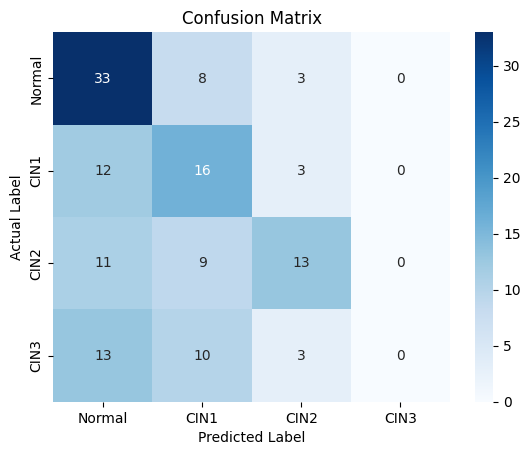

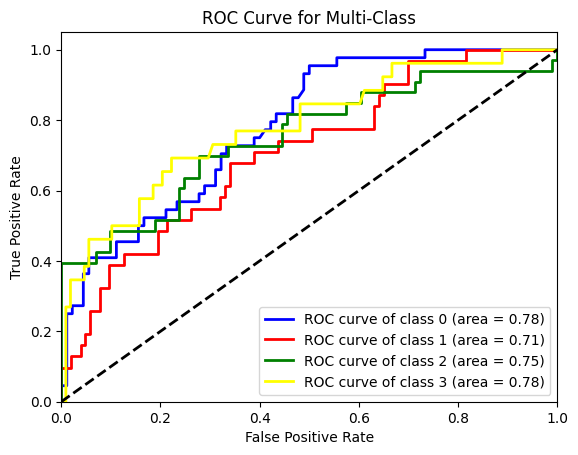

In [19]:
# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(train_generator)
print(f'Train Accuracy: {train_acc:.4f}')
print(f'Train Loss: {train_loss:.4f}')

val_loss, val_acc = model.evaluate(val_generator)
print(f'Val Accuracy: {val_acc:.4f}')
print(f'Val Loss: {val_loss:.4f}')

# Misalnya kamu monitor val_accuracy
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = np.max(history.history['val_accuracy'])

print(f"\nBest epoch: {best_epoch}")
print(f"Validation Accuracy at Best Epoch: {best_val_acc:.4f}")

# === EVALUASI: NILAI TERBAIK ===
training_time = end_time - start_time
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\n🏁 Training selesai dalam {training_time:.2f} detik")
print(f"🏆 Best Epoch: {best_epoch+1}")
print(f"✅ Best Train Acc: {history.history['accuracy'][best_epoch]:.4f}")
print(f"✅ Best Val Acc: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"📉 Best Train Loss: {history.history['loss'][best_epoch]:.4f}")
print(f"📉 Best Val Loss: {history.history['val_loss'][best_epoch]:.4f}")

# Predict the test set
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'CIN1', 'CIN2', 'CIN3']))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'CIN1', 'CIN2', 'CIN3'], yticklabels=['Normal', 'CIN1', 'CIN2', 'CIN3'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green', 'yellow']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()

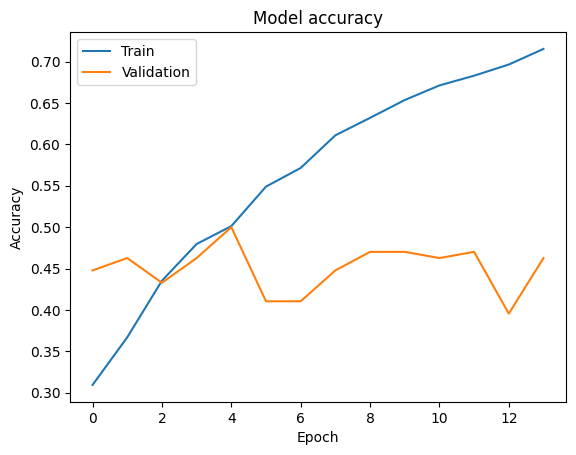

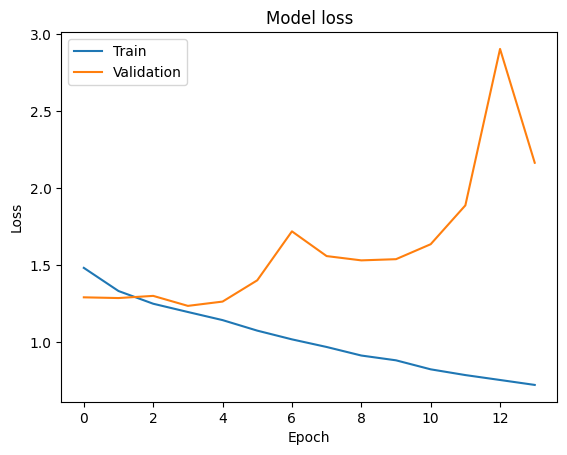

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Calculate sensitivity (recall), precision, and F1-score
sensitivity = recall_score(y_true, y_pred_classes, average=None)
precision = precision_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Calculate specificity
specificity = []
for i in range(3):
    tn = np.sum((y_true != i) & (y_pred_classes != i))
    fp = np.sum((y_true != i) & (y_pred_classes == i))
    specificity.append(tn / (tn + fp))

print(f'Sensitivity: {sensitivity}')
print(f'Precision: {precision}')
print(f'F1-Score: {f1}')
print(f'Specificity: {specificity}')

Sensitivity: [0.75       0.51612903 0.39393939 0.        ]
Precision: [0.47826087 0.37209302 0.59090909 0.        ]
F1-Score: [0.5840708  0.43243243 0.47272727 0.        ]
Specificity: [np.float64(0.6), np.float64(0.7378640776699029), np.float64(0.9108910891089109)]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
